# Dynamic Learner Showcase

Notebook created with the intent of showing how different tecniques deal with a dynamic environment

#### Import statements
Used to import local functions/modules or external libraries inside the notebook.

In [1]:
from ola2022_project.environment.environment import example_environment, Step, UserClassParameters, simple_abrupt_change
from ola2022_project.simulation.simulation import Simulation, create_n, simulate_n 
from ola2022_project.learners import *
from ola2022_project.algorithms.multi_armed_bandits import Mab

import numpy as np
import matplotlib.pyplot as plt
import random

#### Plotting functions
Functions used to plot data onto a graph for an immediate visualization and analysis.

In [2]:
# Helper function that computes the means for n slices of a given dimension for an array
def mean_slices(array, dim, n):
    ret = []
    for i in range(n):
        ret.append(np.mean(array[i * dim : dim * (i + 1)]))
    return ret

# Plot colors
colors = ['aqua', 'black', 'blue', 'blueviolet', 'burlywood', 'cadetblue', 'chocolate', 
          'coral', 'crimson', 'cyan', 'forestgreen', 'fuchsia', 'gold', 'green', 'hotpink', 
          'indigo', 'lime', 'magenta','navy', 'orange', 'purple', 'red', 'salmon', 
          'silver', 'teal', 'turquoise', 'violet']
n_colors = len(colors)

In [3]:
# Function used for quickly plotting multiple experiments onto a graph
def plot_experiments_days(n_days, rewards, breakpoint, days_step=1, show_mean=True, 
                          cumulate=False, show_markers=True, legend=True,
                          names=None):
    # Encapsulate the rewards in a list if the dimensionality is 1
    plot_rewards = rewards
    if np.ndim(rewards) == 1:
        plot_rewards = [rewards]
    # Calculating and shaping data that is going to be shown on the graph
    days = np.arange(1, n_days + 1, days_step)
    n_exp = len(plot_rewards)
    new_n_days = len(days)
    plot_rewards = \
            np.array(list(map(lambda r: mean_slices(r, days_step, new_n_days), plot_rewards)))
    if(cumulate):
        plot_rewards = np.array(list(map(lambda r: np.cumsum(r), plot_rewards)))
    # Graphical tuning
    marker = "." if show_markers else ""
    plot_colors = \
            random.sample(colors, n_exp) if n_exp <= n_colors else random.choice(colors, n_exp)
    plot_names = ["Experiment {n}" for i in range(len(plot_rewards))]
    if names and len(names) >= len(plot_rewards):
        plot_names = names
    # Creating a new figure and plotting the data onto it
    plt.figure()
    
    plt.axvline(x = breakpoint, color = 'teal', label = 'Breakpoint', linestyle='--')
    
    for i, reward in enumerate(plot_rewards):
        plt.plot(days, reward, label=plot_names[i].format(n=i+1), marker=marker, 
                 linestyle='-', color=plot_colors[i])
        if(show_mean):
            mean = [np.mean(plot_rewards[i])] * new_n_days
            plt.plot(days, mean, label="Mean of " + plot_names[i].format(n=i+1), 
                     linestyle='--', color=plot_colors[i])
            
    # Setting labels and showing the figure
    plt.xlabel("days")
    plt.ylabel("reward")
    if legend:
        plt.legend(loc = "best")
        
    plt.show()

In [4]:
# This function exists because jupyter seems to be caching values and does not allow 
# repeatibility in the same notebook
def make_env(rng):
    classes_parameters=[
            [
                UserClassParameters(10, 0.2, 120),
                UserClassParameters(10, 0.15, 120),
                UserClassParameters(8, 0.5, 300),
                UserClassParameters(7, 0.05, 220),
                UserClassParameters(14, 0.15, 170),
            ],
            [
                UserClassParameters(22, 0.5, 190),
                UserClassParameters(20, 0.1, 210),
                UserClassParameters(16, 0.25, 240),
                UserClassParameters(24, 0.03, 80),
                UserClassParameters(20, 0.05, 360),
            ],
            [
                UserClassParameters(33, 0.4, 180),
                UserClassParameters(25, 0.15, 210),
                UserClassParameters(30, 0.35, 240),
                UserClassParameters(31, 0.05, 300),
                UserClassParameters(36, 0.05, 420),
            ],
        ]

    # Creating the environment
    env = example_environment(
        rng=rng,
        total_budget=400,
        class_ratios=[0.3, 0.6, 0.1],
        product_prices=[3, 15, 8, 22, 1],
        classes_parameters=classes_parameters,
        lam=0.5,
        max_items=3,
        graph_fully_connected=True,
        graph_zeros_probability=0.5,
        next_products=[(2, 3), (0, 2), (1, 4), (4, 1), (3, 0)],
        random_noise=1e-3,
        graph=np.array(
            [
                [0, 0, 0.7, 0.4, 0],
                [0.3, 0, 0.8, 0, 0],
                [0, 0.2, 0, 0, 0.2],
                [0, 0.9, 0, 0, 0.8],
                [0.05, 0, 0, 0.25, 0],
            ]
        ),
    )
    return env

#### Environment setup
Create the environment reference with customizable parameters.

In [5]:
plt.style.use('seaborn-v0_8-dark')
# Random Number Generator used as a source of randomness by the environment and the simulation
seed=1500
algorithm = Mab.GPTS
rng = np.random.default_rng(seed=seed)
env = make_env(rng)

## Simulating abrupt change with basic learner
The simulation is ran using a learner with aggregated data and unknown alpha functions. This learner has no ability to adapt to a dynamic environment.

In [6]:
# Simulation separated default parameters
sim_n_days = 80
breakpoint = 35 # Must be smaller than sim_n_days

# Abrupt change parameters
product_losing = 2
lose_interest_factor = 0.15

product_gaining = 1
gain_interest_factor = 2

In [7]:
# Creating the simulation
simulation = Simulation(
    rng,
    env,
    step=Step.ONE,
    n_budget_steps=20,
    population_mean=1000,
    population_variance=10,
    mab_algorithm=algorithm,
)

In [8]:
# Running the simulation
simulation.simulate(breakpoint)
simple_abrupt_change(env, product_losing, lose_interest_factor)
simple_abrupt_change(env, product_gaining, gain_interest_factor)
simulation.simulate(sim_n_days-breakpoint)

base_learner_rewards = simulation.rewards

days:   0%|          | 0/35 [00:00<?, ?it/s]

days:   0%|          | 0/45 [00:00<?, ?it/s]

### Results

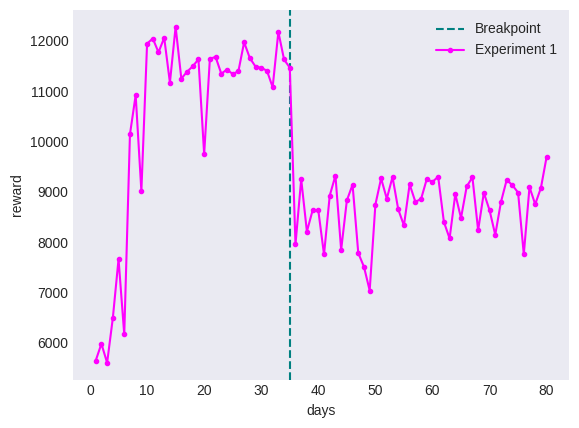

In [9]:
# Plotting the experiment
plt.style.use('seaborn-v0_8-dark')
plot_experiments_days(sim_n_days, base_learner_rewards, breakpoint, days_step=1, 
                      show_mean=False, cumulate=False, show_markers=True, 
                      legend=True, names=["Experiment {n}"])

As we can see, after the abrupt change at day 30, the algorithm is not able to optimize the budget anymore, since the learning process occured mostly before the abrupt change, when the environment was different. The learner learned to prioritize some subcampaigns that after the abrupt change are not profitable anymore.

## Simulating abrupt change with sliding-window learner
Here we use the same exact setting, but employing a sliding-window learner.

In [18]:
rng = np.random.default_rng(seed=seed)
env = make_env(rng)

# Creating the simulation
simulation = Simulation(
    rng,
    env,
    step=Step.FOUR,
    n_budget_steps=20,
    population_mean=1000,
    population_variance=10,
    mab_algorithm=algorithm,
    sliding_window=True,
    window_size=15,
    units_less=False
)

In [19]:
# Running the simulation
simulation.simulate(breakpoint)
simple_abrupt_change(env, product_losing, lose_interest_factor)
simple_abrupt_change(env, product_gaining, gain_interest_factor)
simulation.simulate(sim_n_days-breakpoint)

sw_learner_rewards = simulation.rewards

days:   0%|          | 0/35 [00:00<?, ?it/s]

days:   0%|          | 0/45 [00:00<?, ?it/s]

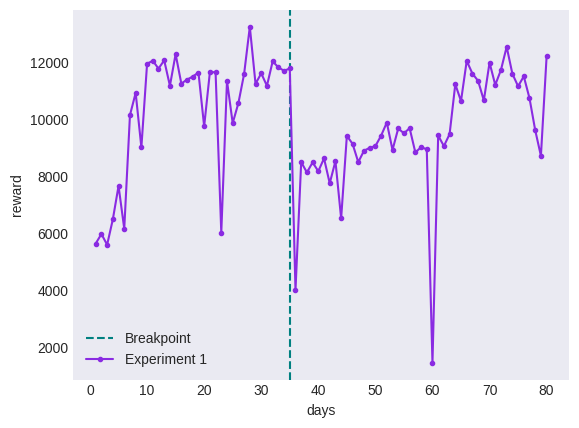

In [20]:
# Plotting the experiment
plot_experiments_days(sim_n_days, sw_learner_rewards, breakpoint, days_step=1, 
                      show_mean=False, cumulate=False, show_markers=True, 
                      legend=True, names=["Experiment {n}"])

After the abrupt change the learner struggles, similarly to the previous case. However, after a while, it adapts to the new environment. This probably happens because at a certain point the window has moved past the "old" environment and started learning completely from the new one.

## Simulating abrupt change with change-detection learner
Here we use the same exact setting, but employing a sliding-window learner.

In [13]:
# Resetting the RNG
rng = np.random.default_rng(seed=seed)
env = make_env(rng)

# Creating the simulation
simulation = Simulation(
    rng,
    env,
    step=Step.FOUR,
    n_budget_steps=20,
    population_mean=1000,
    population_variance=10,
    mab_algorithm=algorithm,
    sliding_window=False,
    threshold=1000,
    threshold_window=6,
    units_less=False
)

In [14]:
# Running the simulation
simulation.simulate(breakpoint)
simple_abrupt_change(env, product_losing, lose_interest_factor)
simple_abrupt_change(env, product_gaining, gain_interest_factor)
simulation.simulate(sim_n_days-breakpoint)

cd_learner_rewards = simulation.rewards

days:   0%|          | 0/35 [00:00<?, ?it/s]

days:   0%|          | 0/45 [00:00<?, ?it/s]

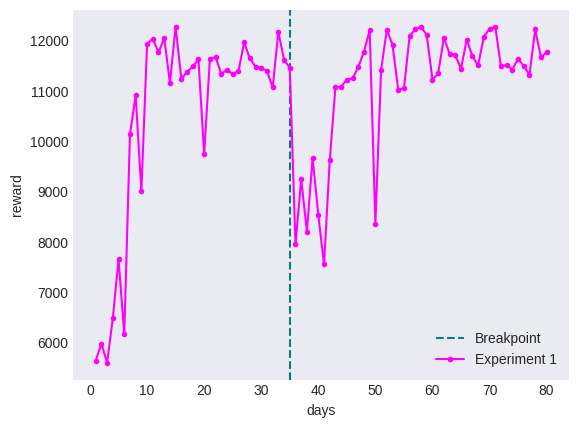

In [15]:
# Plotting the experiment
plot_experiments_days(sim_n_days, cd_learner_rewards, breakpoint, days_step=1, 
                      show_mean=False, cumulate=False, show_markers=True, 
                      legend=True, names=["Experiment {n}"])

The change detection seems to deal really well with the abrupt change.It recovers really quickly from the abrupt change.

In [16]:
from ola2022_project.algorithms.reward_estimator import clairvoyant_reward
rng = np.random.default_rng(seed=seed)

env  = make_env(rng)
clair_reward_before_change = clairvoyant_reward(env, 1000, 400, 21)

simple_abrupt_change(env, product_losing, lose_interest_factor)
simple_abrupt_change(env, product_gaining, gain_interest_factor)

clair_reward_after_change = clairvoyant_reward(env, 1000, 400, 21)

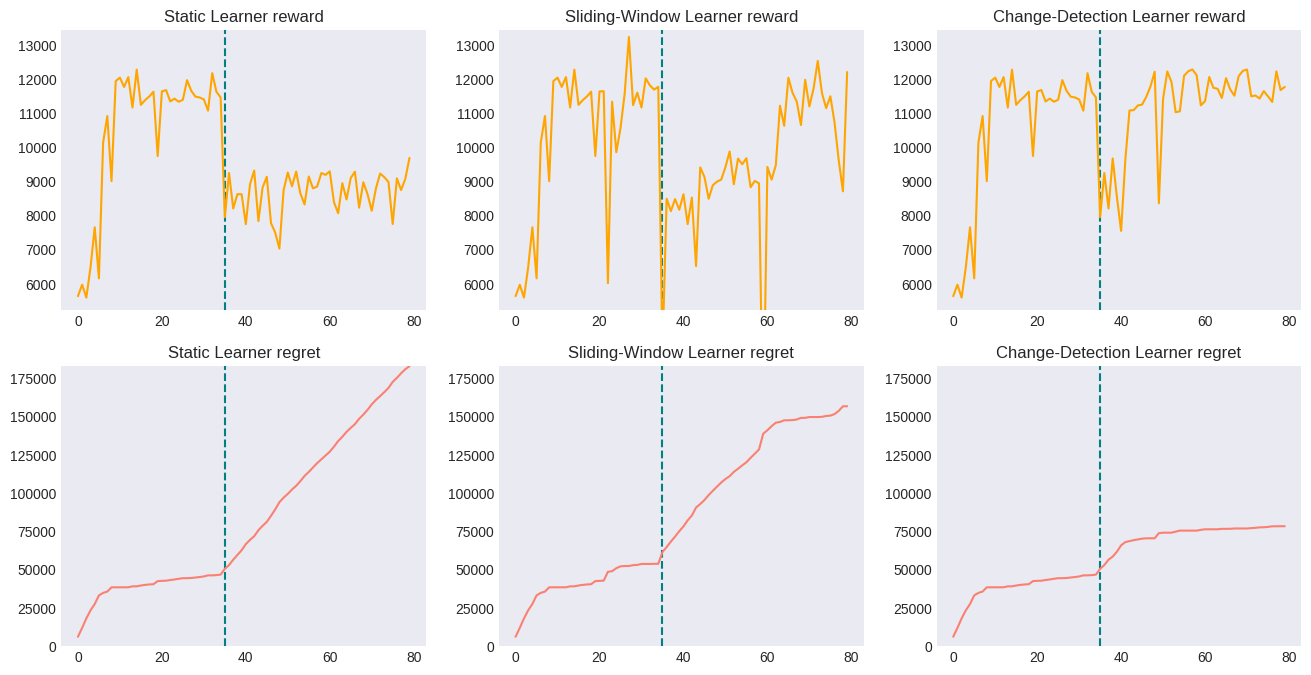

In [21]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(16,8))

rewards = [base_learner_rewards, sw_learner_rewards, cd_learner_rewards]
regrets = []
for rew in rewards:
    regret = np.zeros(sim_n_days)
    regret[:breakpoint] = clair_reward_before_change - rew[:breakpoint]
    regret[breakpoint:] = clair_reward_after_change - rew[breakpoint:]
    regret[regret<0] = 0
    regrets.append(np.cumsum(regret))
    
maximum_reward = np.max(rewards)
maximum_regret = np.max(regrets)

for graph, reward, regret, name in zip(ax.T,
                         rewards, 
                         regrets,              
                         ['Static Learner', 'Sliding-Window Learner', 'Change-Detection Learner']):
    
    graph[0].axvline(x = breakpoint, color = 'teal', linestyle='--', label = 'axvline - full height')
    graph[0].plot(reward, color='orange')
    graph[0].title.set_text(f'{name} reward')
    
    graph[1].axvline(x = breakpoint, color = 'teal', linestyle='--', label = 'axvline - full height')
    graph[1].plot(regret, color='salmon')
    graph[1].title.set_text(f'{name} regret')
    
    graph[0].set_ylim([maximum_reward-8000, maximum_reward+200])
    graph[1].set_ylim([0, maximum_regret])